<a href="https://colab.research.google.com/github/RuiyunHuang/Chicago_Crime_Analysis/blob/master/Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part 0: Environment Setup**

##**0.1 Install package**


In [1]:
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-qf3z15nk
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-qf3z15nk
  Created wheel for folium: filename=folium-0.10.1+6.g4a7532d-py2.py3-none-any.whl size=93921 sha256=968ce31965f0f5be7cc3634a8903600f03b45b1cd3bb35de4d20ea13d5d3fd7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-062rnlf7/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.10.1+6.g4a7532d which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


##**0.2 Import packages**

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import folium as fl
from datetime import datetime

sns.set_palette("husl")
%matplotlib inline

##**0.3 Import data to Colab**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1hkLBV2uhGO6k_BvV6FsQw2nIFZvLfIW2'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('crime.csv')

# **Part 1: Data Cleaning**

In [0]:
raw_data=pd.read_csv('crime.csv')

In [5]:
raw_data.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10786009,HZ554425,12/16/2016 10:30:00 AM,014XX W 78TH ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,612,6.0,17.0,71.0,05,1168161.0,1853026.0,2016,01/07/2020 03:50:13 PM,41.752236,-87.659334,"(41.752235645, -87.659334168)"
1,10734627,HZ494078,10/28/2016 02:00:00 PM,002XX E 92ND ST,0610,BURGLARY,FORCIBLE ENTRY,POOL ROOM,False,False,633,6.0,9.0,49.0,05,1179757.0,1844042.0,2016,01/07/2020 03:50:13 PM,41.727325,-87.617114,"(41.72732535, -87.617114114)"
2,11694006,JC267197,01/01/2016 12:01:00 AM,048XX W WABANSIA AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,2533,25.0,37.0,25.0,17,NaN,NaN,2016,01/06/2020 03:49:40 PM,NaN,NaN,NaN
3,10613199,HZ366157,07/27/2016 12:49:00 AM,116XX S AVENUE M,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE-GARAGE,True,False,433,4.0,10.0,55.0,05,1201591.0,1828417.0,2016,01/06/2020 03:49:40 PM,41.683923,-87.537663,"(41.683922677, -87.53766346)"
4,11940434,JD102754,09/01/2016 08:00:00 AM,059XX S INDIANA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,232,2.0,20.0,40.0,11,NaN,NaN,2016,01/04/2020 03:46:59 PM,NaN,NaN,NaN


In [0]:
raw_data=raw_data.drop(['ID', 'Case Number', 'Location', 'Updated On', 'X Coordinate', 'Y Coordinate'], axis=1);

In [7]:
raw_data.shape

(1063214, 16)

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063214 entries, 0 to 1063213
Data columns (total 16 columns):
Date                    1063214 non-null object
Block                   1063214 non-null object
IUCR                    1063214 non-null object
Primary Type            1063214 non-null object
Description             1063214 non-null object
Location Description    1058984 non-null object
Arrest                  1063214 non-null bool
Domestic                1063214 non-null bool
Beat                    1063214 non-null int64
District                1063213 non-null float64
Ward                    1063194 non-null float64
Community Area          1063208 non-null float64
FBI Code                1063214 non-null object
Year                    1063214 non-null int64
Latitude                1051982 non-null float64
Longitude               1051982 non-null float64
dtypes: bool(2), float64(5), int64(2), object(7)
memory usage: 115.6+ MB


In [9]:
raw_data.isnull().sum()

Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     4230
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       20
Community Area              6
FBI Code                    0
Year                        0
Latitude                11232
Longitude               11232
dtype: int64

#**Part 2: Data Exploration**

###**2.1 Find top 10 crimes**

In [10]:
# take a look at all crime categories
raw_data['Primary Type'].unique()

array(['BURGLARY', 'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE',
       'THEFT', 'NARCOTICS', 'HOMICIDE', 'ROBBERY', 'OTHER OFFENSE',
       'WEAPONS VIOLATION', 'MOTOR VEHICLE THEFT', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'NON-CRIMINAL',
       'INTERFERENCE WITH PUBLIC OFFICER', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'STALKING', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'INTIMIDATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY', 'GAMBLING',
       'NON - CRIMINAL', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING'], dtype=object)

In [0]:
#remove those non-crimes
non_crime=set(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'])
raw_data=raw_data[~raw_data['Primary Type'].isin(non_crime)]

          Primary Type  Number of crimes
0                THEFT            253284
1              BATTERY            198942
2      CRIMINAL DAMAGE            114594
3              ASSAULT             79064
4   DECEPTIVE PRACTICE             75170
5        OTHER OFFENSE             68323
6            NARCOTICS             52304
7             BURGLARY             48615
8  MOTOR VEHICLE THEFT             41644
9              ROBBERY             41540


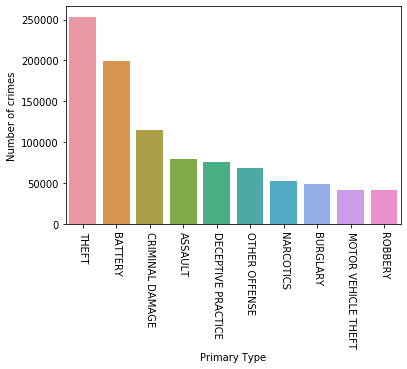

In [12]:
#list top 10 crimes
crime_by_type=raw_data.groupby('Primary Type').size().sort_values(ascending=False).rename('Number of crimes').reset_index().head(10)
print(crime_by_type)
plt.figure()
plt.xticks(rotation=-90)
sns.barplot(x='Primary Type', y='Number of crimes', data=crime_by_type)

###**2.2 List top 10 dangerous districts**

In [13]:
raw_data['District'].unique()

array([ 6., 25.,  4.,  2., 16., 15.,  5.,  7., 20., 14., 19.,  8., 12.,
       22., 10., 17.,  3., 11.,  9., 18., 24.,  1., 31., nan])

  District  Number of crimes
0       11             73960
1        6             65932
2        8             65919
3        1             59903
4       18             59551
5        4             57828
6        7             55844
7       25             54900
8       12             53735
9       10             50073


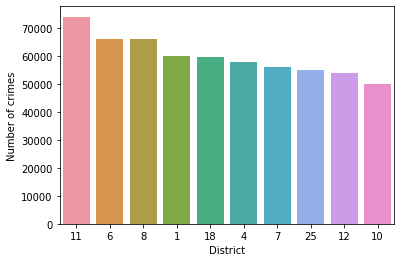

In [14]:
# list top district
crime_by_district=raw_data.groupby('District').size().sort_values(ascending=False).rename('Number of crimes').reset_index().head(10)
crime_by_district['District']=crime_by_district['District'].astype(int).astype(str)
print(crime_by_district)
plt.figure()
sns.barplot(x='District', y='Number of crimes', data=crime_by_district, order=crime_by_district['District'])

###**2.3 Time dependence of crimes**

In [0]:
# parse date 
raw_data['Date']=pd.to_datetime(raw_data['Date'], format='%m/%d/%Y %I:%M:%S %p')
raw_data['Day']=raw_data['Date'].dt.day
raw_data['Month']=raw_data['Date'].dt.month
raw_data['DayofWeek']=raw_data['Date'].dt.dayofweek
raw_data['Hour']=raw_data['Date'].dt.hour

In [0]:
years=[2016, 2017, 2018, 2019]
months_temp=['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
hour_temp=np.arange(0, 25, 1).tolist()

**By month**

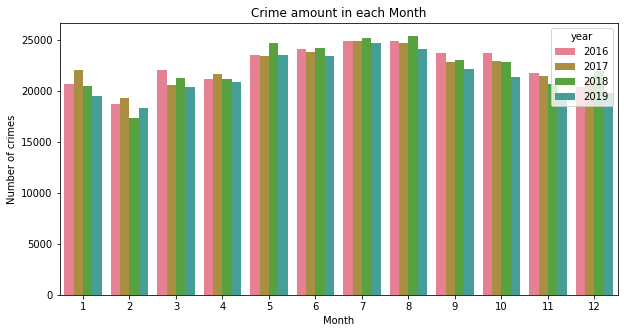

In [17]:
crime_by_Month=pd.DataFrame()
for _ in years:
  tmp=raw_data[raw_data.Year == _].groupby('Month')\
  .size().rename('Number of crimes').reset_index()
  tmp['year']=_
  crime_by_Month=pd.concat([crime_by_Month, tmp])

plt.figure(figsize=[10, 5])
plt.title('Crime amount in each Month')
sns.barplot(x=crime_by_Month.Month, y=crime_by_Month['Number of crimes'], hue=crime_by_Month.year, data=crime_by_Month)

**By day of week**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


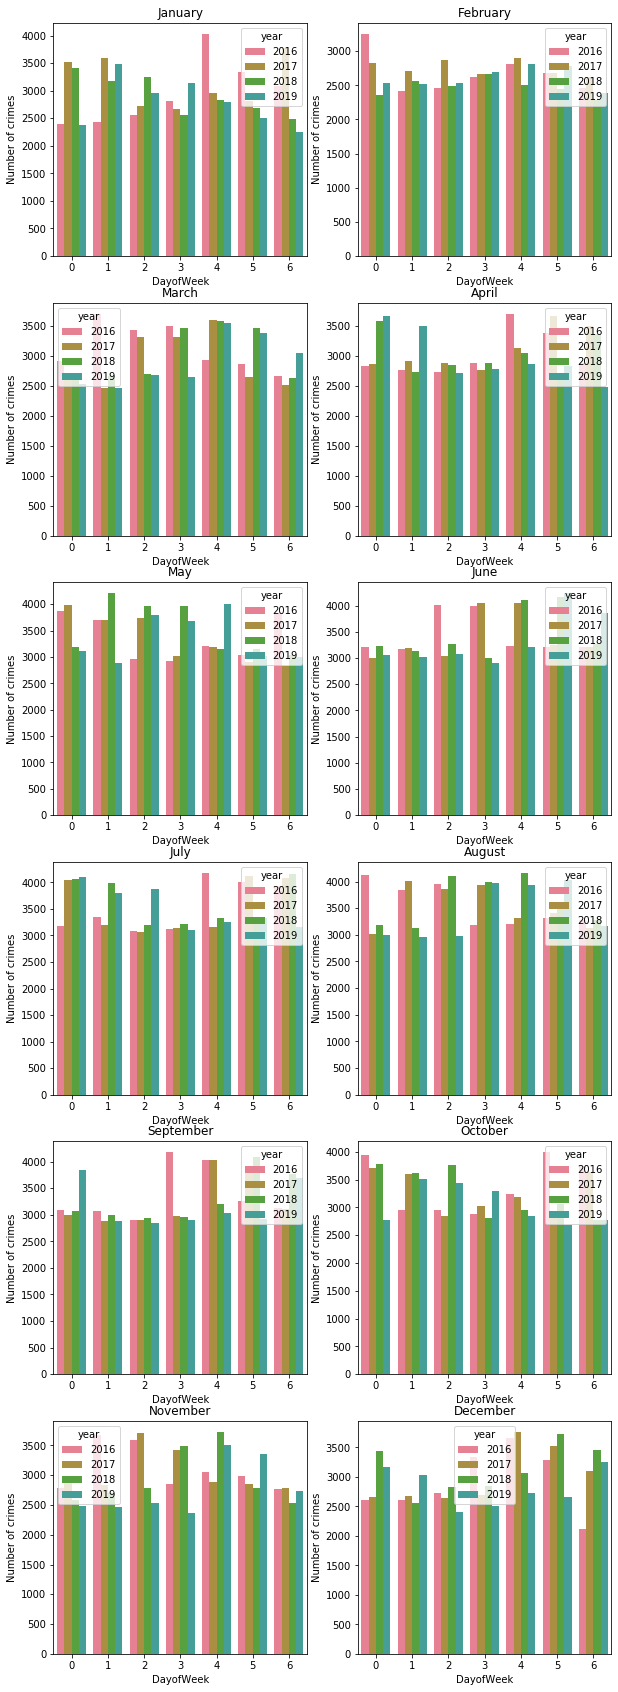

In [18]:
months=np.arange(1, 13, 1)
plt.figure(figsize=[10, 30])
for i in months:
  crime_by_dayofweek=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('DayofWeek')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_dayofweek=pd.concat([crime_by_dayofweek, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.barplot(x=crime_by_dayofweek.DayofWeek, y=crime_by_dayofweek['Number of crimes'], hue=crime_by_dayofweek.year, data=crime_by_dayofweek)

**By hour**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


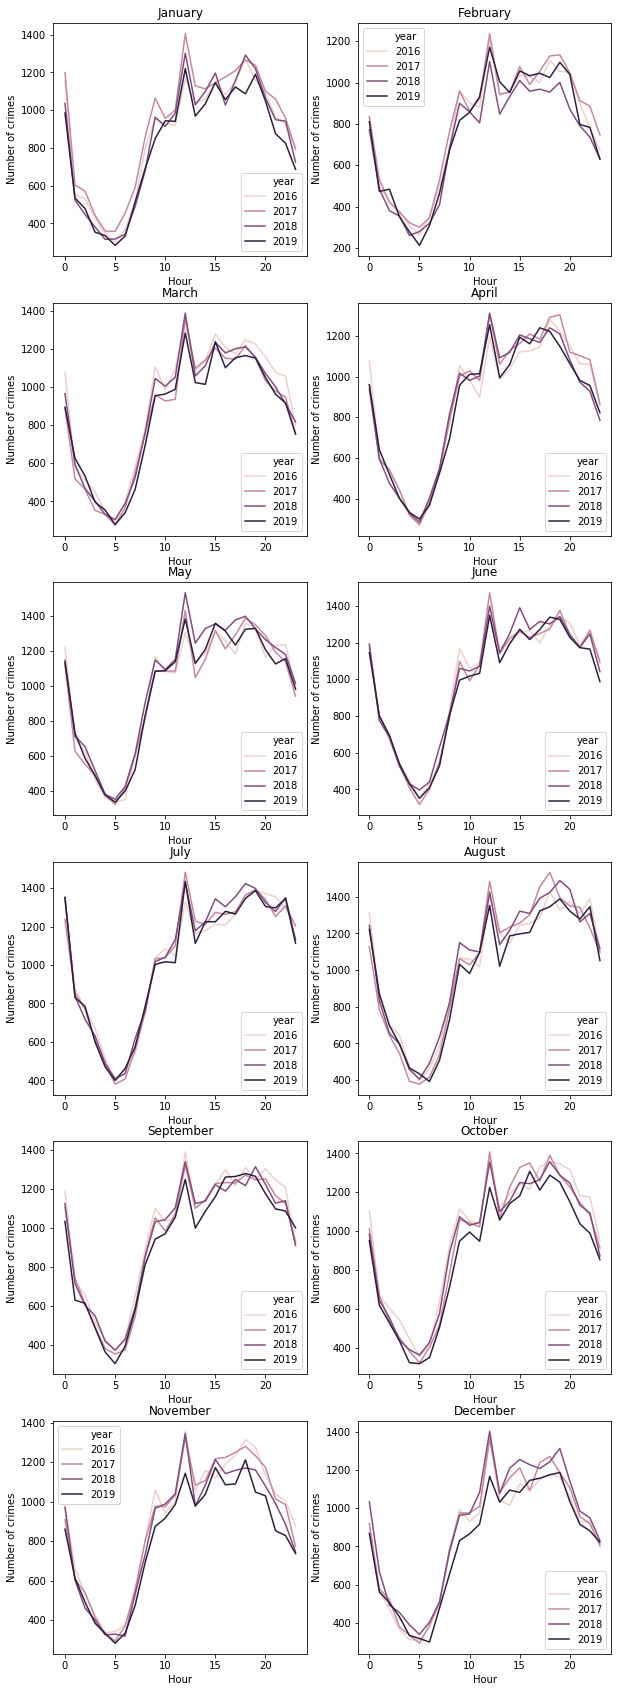

In [19]:
plt.figure(figsize=[10, 30])
for i in months:
  crime_by_hour=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('Hour')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_hour=pd.concat([crime_by_hour, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.lineplot(x=crime_by_hour.Hour, y=crime_by_hour['Number of crimes'], hue=crime_by_hour.year, data=crime_by_hour)

#**Part 3: Visualization**

In [0]:
chicago_cor=[41.8781, -87.6298]
Time_type='Hour'
Crime_type='ROBBERY'

In [0]:
location_list=raw_data[(~raw_data.Latitude.isnull()) & (raw_data.Year == 2019) & (raw_data['Primary Type'] == Crime_type)][['Latitude', 'Longitude', Time_type]]
location_list['xy']=location_list[['Latitude', 'Longitude']].values.tolist()
location_list=location_list[['xy', Time_type]].groupby(Time_type).agg(list)
lc=location_list['xy'].values.tolist()

In [22]:
from folium.plugins import HeatMapWithTime
chicago_cor=[41.8781, -87.6298]
m = fl.Map(location=chicago_cor, zoom_start=11)
HeatMapWithTime(lc, index=location_list.index.tolist(), radius=10).add_to(m)
m

#**Part 4: Modeling**

##**4.1: K-means clustering on locations**

In [0]:
from sklearn.cluster import KMeans

In [0]:
# set summer as tour months
tour_months=set([6, 7, 8])
train_X = raw_data[(raw_data.Year==2019) & (raw_data.Month.isin(tour_months)) & (raw_data['Primary Type'] == Crime_type)][['Latitude', 'Longitude']].dropna()

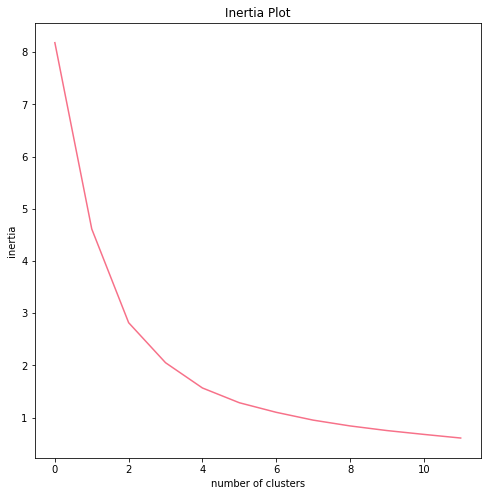

In [67]:
inertia=[]
for n in range(2, 25, 2):
  result=KMeans(n)
  result.fit(train_X)
  inertia.append(result.inertia_)
plt.figure()
plt.plot(np.arange(0, len(inertia)), np.array(inertia))
plt.title('Inertia Plot')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

In [0]:
best=KMeans(5)
best.fit(train_X)
res=best.predict(train_X)

In [0]:
res=pd.concat([train_X.reset_index(drop=True), pd.DataFrame(res, columns=['label'])], axis=1)

In [0]:
regions_sum=res.groupby('label').count().reset_index()

In [0]:
res=res.join(regions_sum, on='label', rsuffix='_0').

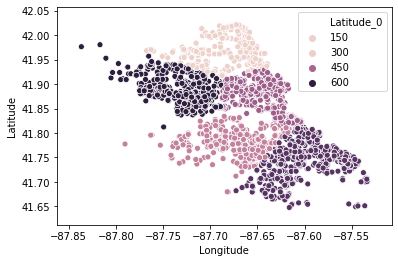

In [140]:
tmp=sns.scatterplot(x=res.Longitude, y=res.Latitude, hue=res.Latitude_0)

###**4.2.1: Data processing**

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
years=[2016, 2017, 2018, 2019]

In [0]:
raw_data['Day']=raw_data['Date'].values.astype('datetime64[D]')
train_crime_by_month = raw_data[raw_data['Year'].isin(years)].groupby('Day').size().rename('Number of crimes').reset_index()
train_crime_by_month=train_crime_by_month.set_index('Day', drop=True)

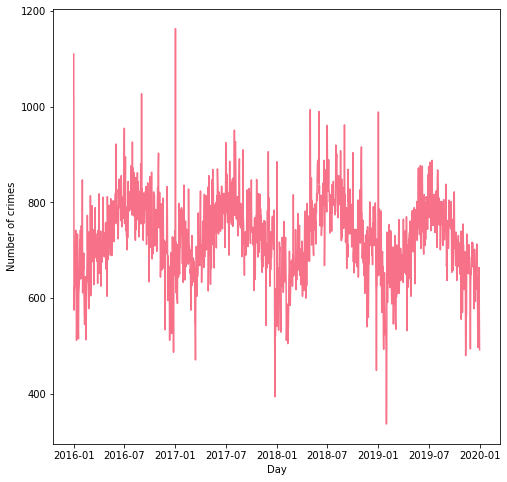

In [304]:
plt.figure()
sns.lineplot(x=train_crime_by_month.index, y=train_crime_by_month['Number of crimes'], data=train_crime_by_month)

###**4.2.2: Seasonal decomposition**

Text(0.5, 0.98, 'Additive Decompose')

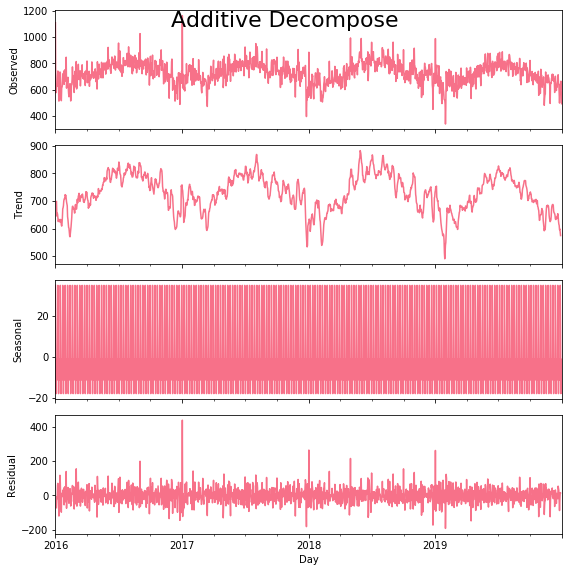

In [305]:
additive=sm.tsa.seasonal_decompose(train_crime_by_month)

plt.rcParams.update({'figure.figsize': (8,8)})
additive.plot().suptitle('Additive Decompose', fontsize=22)

###**4.2.3: Stationary check**

In [0]:
train_data=train_crime_by_month.loc['2016-01-01':'2018-12-01']
test_data=train_crime_by_month.loc['2019-01-01':]

In [308]:
# stationary check
def ADF_check(data):
  result = sm.tsa.stattools.adfuller(data['Number of crimes'])
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
      print('Critial Values:')
      print(f'{key}, {value}')

print('**Train_data**')
ADF_check(train_data)
print('**Test_data**')
ADF_check(test_data)

**Train_data**
ADF Statistic: -3.3183324376360113
p-value: 0.01407863879899089
Critial Values:
1%, -3.436581300425998
Critial Values:
5%, -2.8642912936257905
Critial Values:
10%, -2.5682348955818357
**Test_data**
ADF Statistic: -1.2140913902313424
p-value: 0.6675047673378167
Critial Values:
1%, -3.4491725955218655
Critial Values:
5%, -2.8698334971428574
Critial Values:
10%, -2.5711883591836733


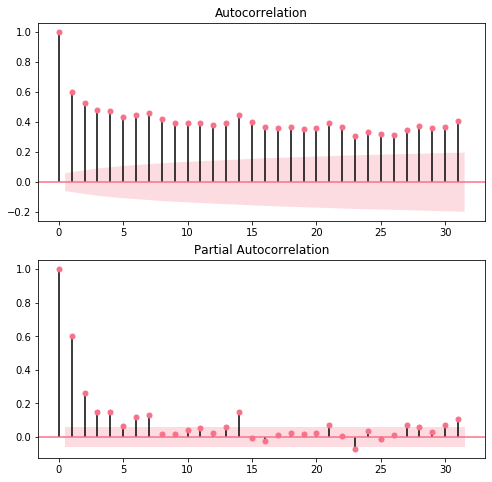

In [309]:
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 

fig, ax = plt.subplots(nrows=2,ncols=1)
plot_acf(train_data.values, ax = ax[0])
plot_pacf(train_data.values, ax = ax[1])
display()

###**4.2.4 Parameter selection and model testing**

In [0]:
train_crime_by_month=train_crime_by_month.asfreq('D')

In [0]:
train_data=train_crime_by_month.loc['2016-01-01':'2018-12-31']
test_data=train_crime_by_month.loc['2019-01-01':]

In [0]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [321]:
cur_min=float('inf')
final=[]
i=0
for _order in pdq:
  for _param in seasonal_pdq:
    model=SARIMAX(train_data, order=_order, 
              seasonal_order=_param)
    result=model.fit()
    i+=1
    print('fitting {}:'.format(i))
    if result.aic < cur_min:
      final=[model, _order, _param]
      cur_min=result.aic

fitting 1:
fitting 2:
fitting 3:
fitting 4:
fitting 5:
fitting 6:
fitting 7:
fitting 8:
fitting 9:
fitting 10:
fitting 11:
fitting 12:
fitting 13:
fitting 14:
fitting 15:
fitting 16:
fitting 17:
fitting 18:
fitting 19:
fitting 20:
fitting 21:
fitting 22:
fitting 23:
fitting 24:
fitting 25:
fitting 26:
fitting 27:
fitting 28:
fitting 29:
fitting 30:
fitting 31:
fitting 32:
fitting 33:
fitting 34:
fitting 35:
fitting 36:
fitting 37:
fitting 38:
fitting 39:
fitting 40:
fitting 41:
fitting 42:
fitting 43:
fitting 44:
fitting 45:


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitting 46:
fitting 47:
fitting 48:
fitting 49:
fitting 50:
fitting 51:
fitting 52:
fitting 53:
fitting 54:
fitting 55:
fitting 56:
fitting 57:
fitting 58:
fitting 59:
fitting 60:
fitting 61:
fitting 62:
fitting 63:
fitting 64:


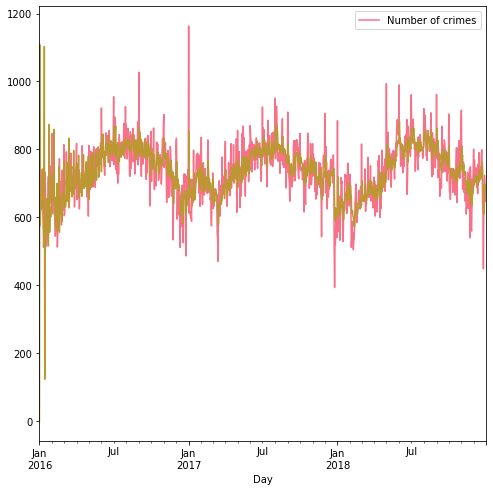

In [322]:
model=final[0]
fig, ax = plt.subplots()
ax = train_data.plot(ax=ax)
pred = result.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred.predicted_mean.plot(ax=ax)
display()

In [323]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                   Number of crimes   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6036.490
Date:                            Tue, 21 Jan 2020   AIC                          12082.981
Time:                                    23:26:11   BIC                          12107.918
Sample:                                01-01-2016   HQIC                         12092.422
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2577      0.027      9.682      0.000       0.206       0.310
ma.L1         -0.8966      0.016    -56.164      0.000      -0.928      -0.865
ar.S.L12      -0.0469      0.029     -1.624      0.104      -0.103       0.010
ma.S.L12      -0.9996      0.641     -1.558      0.119      -2.257       0.258
sigma2      3859.5107   2460.842      1.568      0.117    -963.650    8682.672
===================================================================================
Ljung-Box (Q):                       93.31   Jarque-Bera (JB):              1299.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

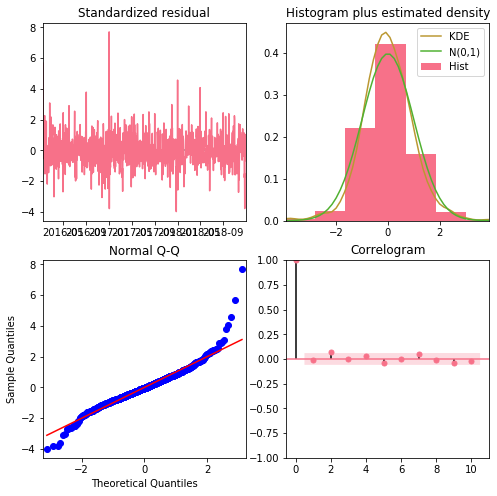

In [324]:
result.plot_diagnostics()
plt.show()

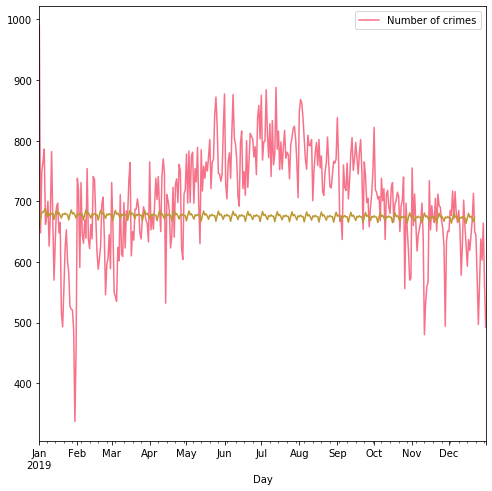

In [325]:
fig, ax = plt.subplots()
ax = test_data.plot(ax=ax)
pred = result.get_forecast(steps=356)
fig=pred.predicted_mean.plot()
display()